In [ ]:
https://www.kaggle.com/code/imperiopts/forecasting-next-month-s-individual-product-sales

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import glob
from functools import reduce


%pip install deep_translator
from deep_translator import GoogleTranslator as gt

#text clustering library
%pip install textpack
from textpack import tp


from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose



#ML libraries
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split



import warnings
warnings.filterwarnings('ignore')

#figsizes for all plots
figsize = (18, 5)

Note: you may need to restart the kernel to use updated packages.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sparse-dot-topn: filename=sparse_dot_topn-0.3.1-cp37-cp37m-linux_x86_64.whl size=2196419 sha256=a671691a306ee66365c960e598f12836ff48f620a436a2b2efb24283e5a14aae
  Stored in directory: /root/.cache/pip/wheels/3b/3e/02/4ee8cb28ed8b608d530bc43402518a895db8ce89aff8ca4e1f
Successfully built sparse-dot-topn
Note: you may need to restart the kernel to use updated packages.


# Loading all files from the directory as DataFrames

In [2]:
import os
#Loading all files in Kaggle kernel
filesList = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        
        file = os.path.join(dirname, filename)    
        fileExt = file[60:-4] #Get the name of the files following the current pattern

        #read each file in their variable name
        exec('{:s}_set = pd.read_csv("{:s}")'.format(fileExt, file)) 
        
        # -- Display the files that will be loaded and the varible names
#         print('{:s}_set = pd.read_csv("{:s}")'.format(fileExt, file))
        

        #append list of files
        filesList.append('{:s}_set'.format(fileExt))

filesList

['items_set',
 'sample_submission_set',
 'item_categories_set',
 'sales_train_set',
 'shops_set',
 'test_set']

# Join data into consolidated datasets to work better

I will join the data transforming an OLTP like schema to an OLAP like schema, to work better with our datasets

In [3]:
data = pd.merge(sales_train_set, items_set, on='item_id', how='left')
data = pd.merge(data, shops_set, on='shop_id', how='left')
data = pd.merge(data, item_categories_set, on='item_category_id', how='left')

#Use date column as datetime type
sales_train_set.date = pd.to_datetime(sales_train_set.date, format="%d.%m.%Y")
data.date = pd.to_datetime(data.date, format="%d.%m.%Y")

data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


## EDA - Exploratory Data Analysis

Now that I have the data all in one set, let's move on to the exploratory analysis step to better understand what's in our hands.

### Translate the name of the stores to understand better

I noticed that there are some store names that seem to be duplicates, as they are very similar. So I merged these stores into one ID.


In [4]:
shops_set['translated'] = shops_set.shop_name.apply(lambda x: gt(source='ru', target='en').translate(x))

In [5]:
shops_set[[ 'shop_id', 'translated']].sort_values(by='translated')

,shop_id,translated
0,0,"!Yakutsk Ordzhonikidze, 56 francs"
1,1,"!Yakutsk shopping center ""Central"" franc"
2,2,"Adygea shopping center ""Mega"""
3,3,"Balashikha SEC ""October-Kinomir"""
56,56,"Chekhov SEC ""Carnival"""
55,55,Digital warehouse 1C-Online
12,12,E-shop online
15,15,"Kaluga SEC ""XXI century"""
13,13,"Kazan shopping center ""Bekhetle"""
14,14,"Kazan shopping center ""Parkhouse"" II"


### Investigate if stores on shoppings have greater performance

I didn't found any significant difference between store numbers, in general.

In [6]:
data = pd.merge(data, shops_set[['shop_id', 'translated']], on='shop_id', how='left')

In [7]:
data.groupby(['translated']).sum()['item_cnt_day'].sort_values(ascending=False)

translated
Moscow shopping center "Semenovsky"                  310777.0
Moscow SEC "Atrium"                                  241920.0
Khimki shopping center "Mega"                        185790.0
Moscow shopping center "MEGA Teply Stan" II          184557.0
St. Petersburg TC "Nevsky Center"                    144934.0
Yakutsk Ordzhonikidze, 56                            141107.0
Moscow shopping center "MEGA Belaya Dacha II"        136657.0
Voronezh (Plekhanovskaya, 13)                        100489.0
Yakutsk shopping center "Central"                     81734.0
Sergiev Posad shopping center "7Ya"                   78990.0
Chekhov SEC "Carnival"                                78079.0
Tyumen shopping center "Goodwin"                      76238.0
E-shop online                                         73478.0
Kursk shopping center "Pushkinsky"                    73455.0
Kaluga SEC "XXI century"                              71201.0
N.Novgorod SEC "Fantastica"                           69016

In [8]:
#if there is shopping in 'translated', separate to analyse
wordToAnalyse = 'shopping'
group1 = data.loc[data['translated'].str.contains(wordToAnalyse, case=False)]
group2 = data.loc[ ~ data['translated'].str.contains(wordToAnalyse, case=False)]

#print each group mean
print('Difference between groups:', group1.item_cnt_day.mean() - group2.item_cnt_day.mean())


Difference between groups: -0.044692637694776716


After analysing the shops dataset, I noticed that some stores have similar names, so I will attribute the same ID for them.

In [9]:
data.shop_id = data.shop_id.replace({10:11, 0:57, 1:58})

### Looking for nulls in data

I found no null data, what is great.

In [10]:
#Find out if we have null data
((data.isna().sum()/data.isna().count())*100).sort_values(ascending=False)

date                  0.0
date_block_num        0.0
shop_id               0.0
item_id               0.0
item_price            0.0
item_cnt_day          0.0
item_name             0.0
item_category_id      0.0
shop_name             0.0
item_category_name    0.0
translated            0.0
dtype: float64

### The 'item_cnt_day' and 'price' features

In [11]:
print('item price description:')
round(data.item_price.describe())

item price description:


count    2935849.0
mean         891.0
std         1730.0
min           -1.0
25%          249.0
50%          399.0
75%          999.0
max       307980.0
Name: item_price, dtype: float64

In [12]:
print('item count description:')
round(data.item_cnt_day.describe())

item count description:


count    2935849.0
mean           1.0
std            3.0
min          -22.0
25%            1.0
50%            1.0
75%            1.0
max         2169.0
Name: item_cnt_day, dtype: float64

In [13]:
perc1 = round(data[data['item_cnt_day'] < 0].count()['date'] / data['item_cnt_day'].sum(),5)
perc2 = round(data[data['item_price'] < 0].count()['date'] / data['item_price'].sum(),5)

print('Proportion of negative values on item_cnt_day feature:', perc1*100, '%')
print('Proportion of negative values on item_price feature:', perc2*100, '%')


Proportion of negative values on item_cnt_day feature: 0.202 %
Proportion of negative values on item_price feature: 0.0 %


There are negative numbers on both variables and a lot of outliers, specially on [item_price]. The negative values could mean returned items, difference found on inventory, etc. 
For the study I will handle outliers and change remaining negative values by the mode (in the [item_cnt_day]) or by 0 (in the [item_price] variable).

<AxesSubplot:title={'center':'Outliers of item_cnt_day before adjust'}, xlabel='item_cnt_day'>

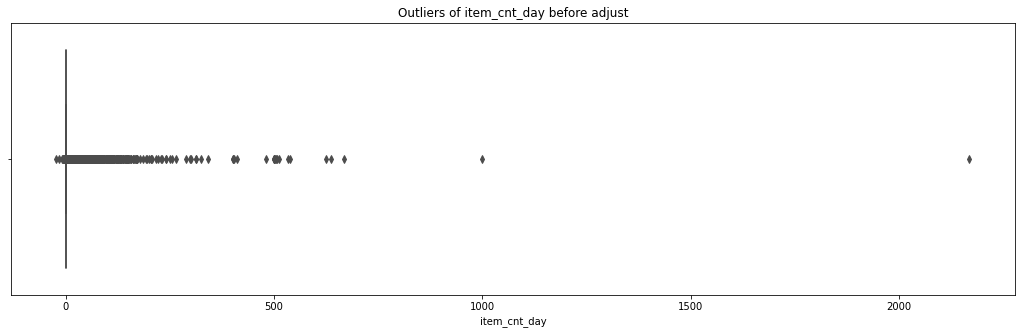

In [14]:
#distribution of Item cnt day considering outliers
plt.figure(figsize=figsize)
plt.title('Outliers of item_cnt_day before adjust')
sns.boxplot(x=data['item_cnt_day'], color='red')

In [15]:
def removeOutliers(data, column, q1, q3):
  #Detect the outliers using IQR technique

  q1_value = data[column].quantile(q1)
  q3_value = data[column].quantile(q3)
  iqr = q3_value - q1_value
  
  #Upper and Lower Limits
  upper = q3_value + 1.5 * iqr
  lower = q1_value - 1.5 * iqr

  print("Lower bound:", lower)
  print("Upper bound:", upper)
  
  # new_df = data[data['Income'] > upper]
  # new_df = data[data['Income']  < lower]

  # Capping (if value is above ou below defined limit, it will be setted to the limit)
  newColumn = column + '_Ol' 

  data[newColumn] = np.where(data[column] > upper, upper, 
                            np.where(data[column] < lower, lower,
                            data[column]))

  print("=" *50)
  print('New Column name is:', newColumn)

  mode1 = data[newColumn].mode()

  #If we have negative values, change for the mode.
  data[newColumn] = data[newColumn].mask(data[newColumn] < 0, float(mode1))

  #print result described
  print("=" *50)
  print('item count description:')
  print(round(data[newColumn].describe()))

  # #distribution of Income without the greater outliers
  # plt.figure(figsize=figsize)
  # plt.title('Outliers of item_cnt_day after adjust')
  # sns.boxplot(x=data['item_cnt_day_ol'], color='red')


In [16]:
removeOutliers(data, 'item_cnt_day', 0.01, 0.9)

Lower bound: -0.5
Upper bound: 3.5
New Column name is: item_cnt_day_Ol
item count description:
count    2935849.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            4.0
Name: item_cnt_day_Ol, dtype: float64


In [17]:
# fill negative values from price with 0
data['item_price'] = data['item_price'].mask(data['item_price'] < 0, 0)
round(data['item_price'].describe())

count    2935849.0
mean         891.0
std         1730.0
min            0.0
25%          249.0
50%          399.0
75%          999.0
max       307980.0
Name: item_price, dtype: float64

#### Plot [item_cnt_day] over time to verify seasonality and trends 

<AxesSubplot:title={'center':'Item count sum over time "months"'}, xlabel='date_block_num'>

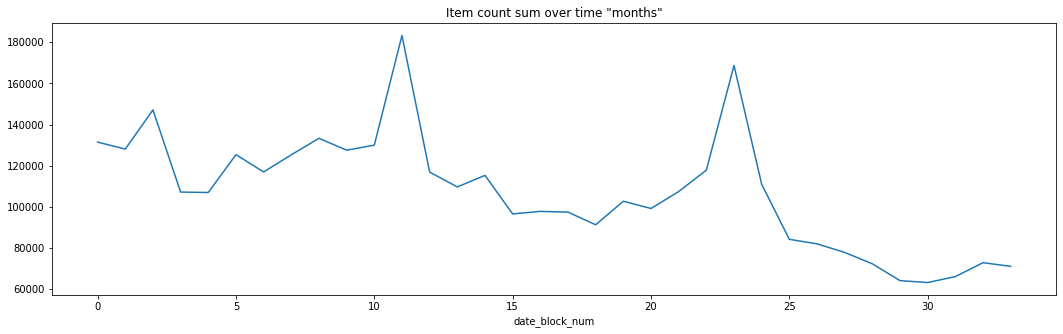

In [18]:
# #adding month and year columns
# sales_train_set['year'] = sales_train_set['date'].dt.year
# sales_train_set['month'] = sales_train_set['date'].dt.month

#item count over time
data.groupby(['date_block_num']).sum()['item_cnt_day'].plot(figsize=figsize, title='Item count sum over time "months"')

#Same as below:
# sales_train_set.groupby([sales_train_set.index.year, sales_train_set.index.month])['item_cnt_day'].sum().plot(figsize=figsize)

<AxesSubplot:title={'center':'Item price sum over time "months"'}, xlabel='date_block_num'>

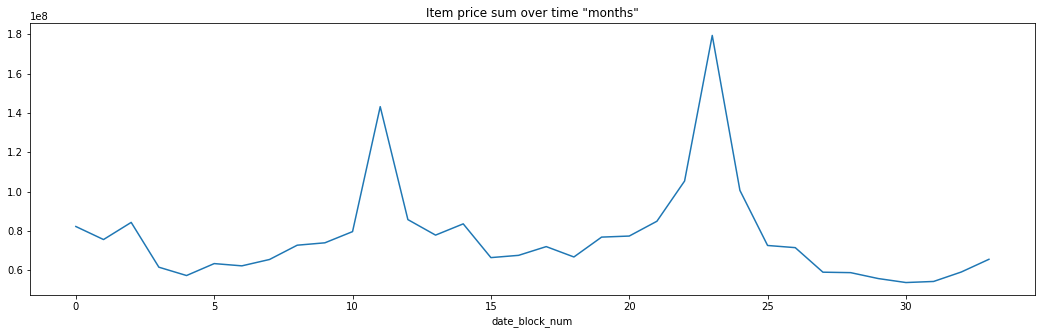

In [19]:
#item price over time
data.groupby(['date_block_num']).sum()['item_price'].plot(figsize=figsize, title='Item price sum over time "months"')

In [20]:
#set date index to use the dataset in decomposing technique
data = data.set_index('date', inplace=False)

dataTimeMean = pd.DataFrame(data.resample('M')['item_cnt_day'].sum()) #resample using months as parameter
# dataTimeMean = dataTimeMean.fillna(0)
# dataTimeMean.drop(dataTimeMean.tail(8).index, inplace=True) # Drop the last observations with 0 

#Decompose Time Series
decompose = seasonal_decompose(dataTimeMean, extrapolate_trend=12)

#Trend
obs = decompose.observed
#Trend
trend = decompose.trend
#Seazonal
seazon = decompose.seasonal
#Error
random = decompose.resid

<AxesSubplot:xlabel='date', ylabel='resid'>

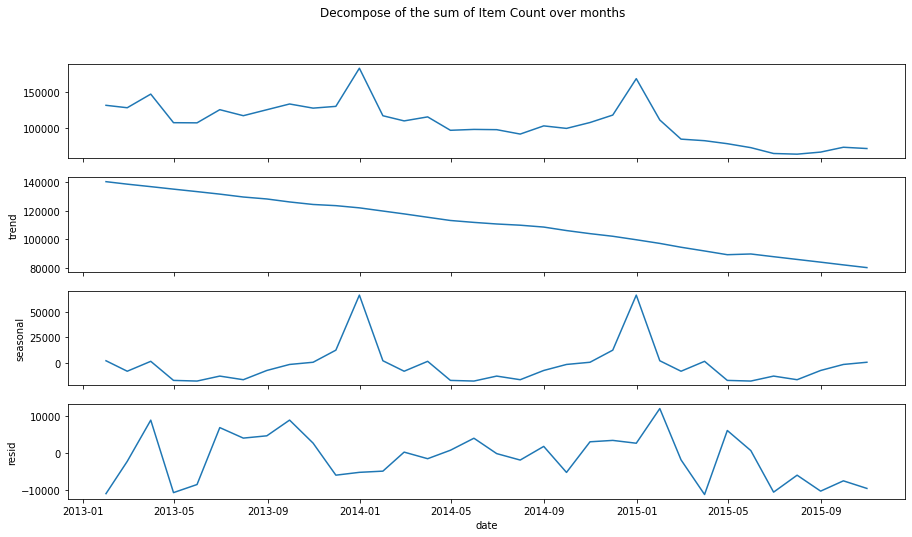

In [21]:
#plot
fig, axes = plt.subplots(4, 1, figsize=(15,8), sharex=True)
fig.suptitle('Decompose of the sum of Item Count over months')

sns.lineplot(x=obs.index, y=obs, ax=axes[0], data=obs)
sns.lineplot(x=trend.index, y=trend, ax=axes[1], data=trend)
sns.lineplot(x=seazon.index, y=seazon, ax=axes[2], data=seazon)
sns.lineplot(x=random.index, y=random, ax=axes[3], data=random)

<AxesSubplot:title={'center':'Seazonality over months'}, xlabel='date'>

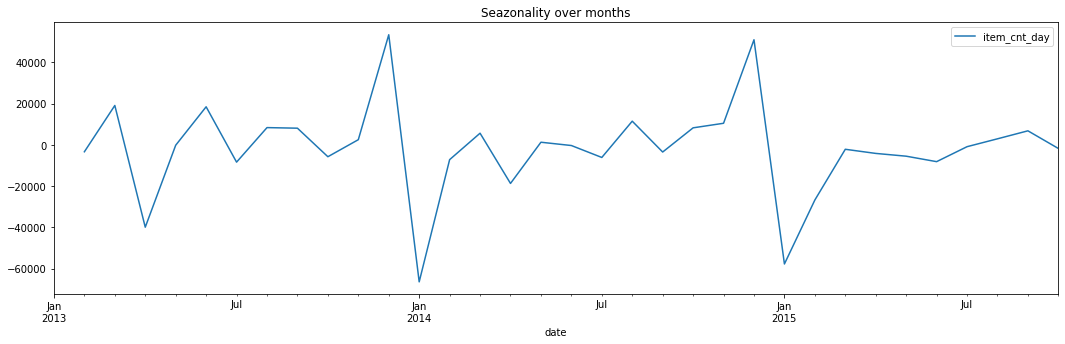

In [22]:
#Seazonality analysis (De-trending)
dataTimeMean.diff(1).plot(figsize=figsize, title='Seazonality over months')

<AxesSubplot:title={'center':'Seazonality of item count over months'}, xlabel='date'>

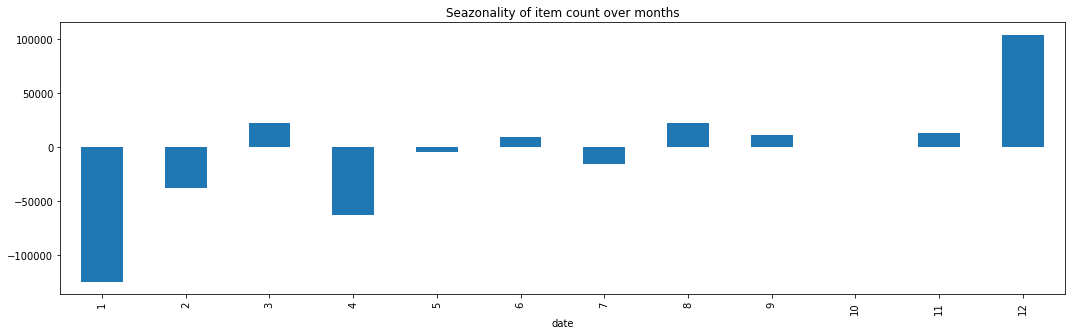

In [23]:
#Seazonality of item counts
dataTimeMean.item_cnt_day.diff(1).groupby(dataTimeMean.index.month).sum().plot(kind='bar', figsize=figsize, title='Seazonality of item count over months')

<AxesSubplot:xlabel='date'>

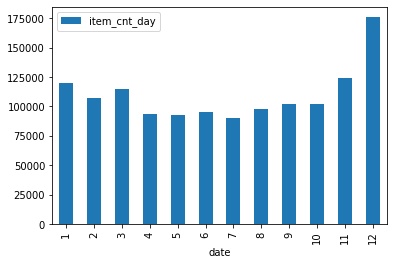

In [24]:
dataTimeMean.groupby(dataTimeMean.index.month).mean().plot(kind='bar')

I then noticed a strong element of seasonality, indicating that in January the sum of items is always lower, after a large peak in December.
I also observed a general downward trend in the number of items, as shown by the downward curve of the 'trend' chart. 

### Best stores classification

I will define the best stores within the dataset

<AxesSubplot:title={'center':'Item count by store'}, xlabel='shop_id'>

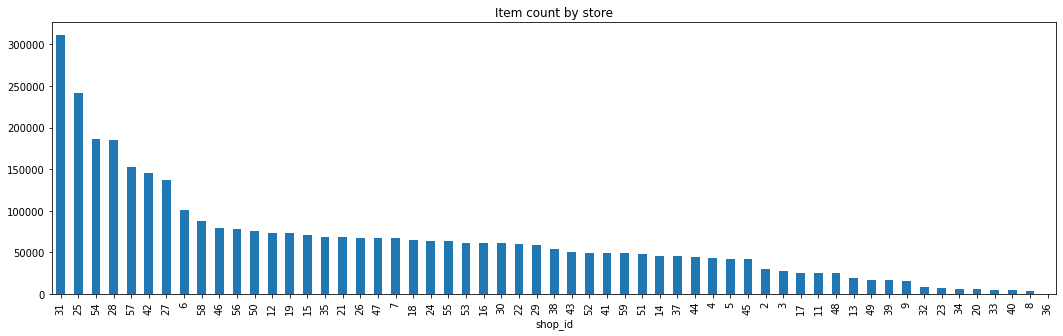

In [25]:
#item count by store
data.groupby(['shop_id']).sum()['item_cnt_day'].sort_values(ascending=False).plot(kind='bar', figsize=figsize, title='Item count by store')

I noticed that in the general analysis, stores 31, 25, 54 and 28 had the best performance in terms of the number of items sold. However, we know that the dataset has stores that were not operational during the entire period, so we will also evaluate the average sales taking into account the number of days that the store was operating (period between the first and last store registration in the dataset), which gives insight into which stores did best in the time they were in operation. 

#### Feature creation (operating days)

In [26]:
listShop = []
listDays = []

for i in range(len(shops_set.shop_id)):
    a = data[data['shop_id'] == i].index.max()
    b = data[data['shop_id'] == i].index.min()
    opDays = (a-b).days

    # print('Store {} had {} days operating'.format(i, opDays))
    listShop.append(i) 
    listDays.append(opDays)

daysOps = pd.DataFrame({'shop_id': listShop,
                        'opDays': listDays})

#insert on new dataset the mean of item count considering the operation days
daysOps['meanByOpDays'] = data.groupby(['shop_id']).sum()['item_cnt_day'] / daysOps['opDays']
daysOps = daysOps.dropna(axis=0)

daysOps.sort_values(by='meanByOpDays', ascending=False).head()

,shop_id,opDays,meanByOpDays
31,31,1032.0,301.140504
25,25,1032.0,234.418605
54,54,842.0,220.653207
28,28,1033.0,178.661181
57,57,1031.0,148.217265


<AxesSubplot:title={'center':'Item count by store operating days'}>

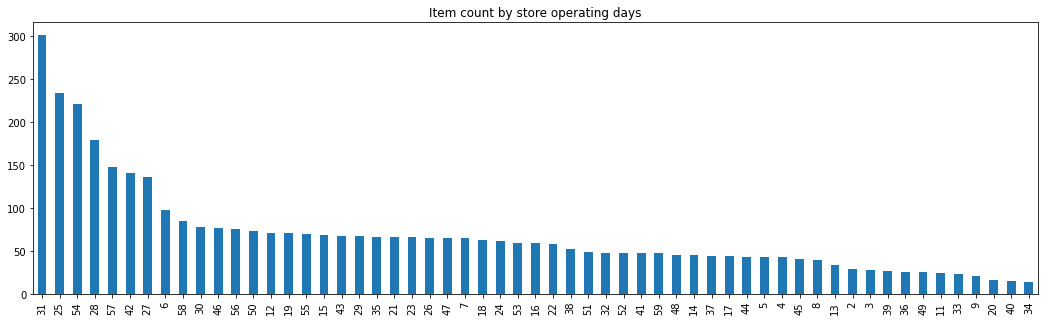

In [27]:
#item count by store (mean)
daysOps['meanByOpDays'].sort_values(ascending=False).plot(kind='bar', figsize=figsize, title='Item count by store operating days')

## Tests for predictions

I'll start with predictions, testing linear regression algorithms

#### Cluster similar items using Text Pack

In [28]:
itemCluster = tp.TextPack(items_set, ['item_name'], match_threshold=0.1, ngram_remove=r'[,-./]', ngram_length=3)
itemCluster.run(column_name='clustered')

Building the TF-IDF, Cosine & Coord matrices...
Building the group lookup...
Adding grouped columns to data frame...
Ready for export


In [29]:
print('Clustering reduced the items by text similatiry into {} categories'.format(items_set.clustered.nunique()))

Clustering reduced the items by text similatiry into 12 categories


In [30]:
items_set['category'] = pd.factorize(items_set.clustered)[0]

In [31]:
items_set = items_set.drop('clustered', axis=1)
items_set

,item_name,item_id,item_category_id,category
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,0
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,0
4,***КОРОБКА (СТЕКЛО) D,4,40,0
...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,0
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,0
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,0
22168,Яйцо для Little Inu,22168,62,1


In [32]:
#merge clustering result into merged data set
data = data.reset_index() #reset index to avoid losing date index

data = pd.merge(data, items_set[['category','item_id']], on='item_id', how='left')

data = data.set_index('date', inplace=False) #reset to date index again

In [33]:
data.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,translated,item_cnt_day_Ol,category
date,,,,,,,,,,,,
2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,"Yaroslavl shopping center ""Altair""",1.0,1
2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,"Moscow SEC ""Atrium""",1.0,1
2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,"Moscow SEC ""Atrium""",1.0,1
2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,"Moscow SEC ""Atrium""",1.0,1
2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,"Moscow SEC ""Atrium""",1.0,1


In [34]:
data = data[['date_block_num','shop_id','item_id','item_price','item_category_id','item_cnt_day_Ol', 'category']]
data

,date_block_num,shop_id,item_id,item_price,item_category_id,item_cnt_day_Ol,category
date,,,,,,,
2013-01-02,0,59,22154,999.00,37,1.0,1
2013-01-03,0,25,2552,899.00,58,1.0,1
2013-01-05,0,25,2552,899.00,58,1.0,1
2013-01-06,0,25,2554,1709.05,58,1.0,1
2013-01-15,0,25,2555,1099.00,56,1.0,1
...,...,...,...,...,...,...,...
2015-10-10,33,25,7409,299.00,55,1.0,1
2015-10-09,33,25,7460,299.00,55,1.0,1
2015-10-14,33,25,7459,349.00,55,1.0,1


#### Disregarding stores with more than X days inoperative

In [35]:
#find the shops with more than 30 days down, to set 0 for each item.
listShopsDown = []

for i in range(len(data.shop_id.unique())):
    a = data[data['shop_id'] == i].index.max()
    max = data.index.max()

    
    if (a - max).days < -30:
        listShopsDown.append(i) 
    else:
        pass

print('Shops to desconsider:', listShopsDown)

data_pred = data.query('shop_id != @listShopsDown') #remove stores from the data set therefore
data_pred

Shops to desconsider: [8, 13, 17, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]


,date_block_num,shop_id,item_id,item_price,item_category_id,item_cnt_day_Ol,category
date,,,,,,,
2013-01-02,0,59,22154,999.00,37,1.0,1
2013-01-03,0,25,2552,899.00,58,1.0,1
2013-01-05,0,25,2552,899.00,58,1.0,1
2013-01-06,0,25,2554,1709.05,58,1.0,1
2013-01-15,0,25,2555,1099.00,56,1.0,1
...,...,...,...,...,...,...,...
2015-10-10,33,25,7409,299.00,55,1.0,1
2015-10-09,33,25,7460,299.00,55,1.0,1
2015-10-14,33,25,7459,349.00,55,1.0,1


#### Parcial auto correlation function (pac) to determine auto correlation between lags

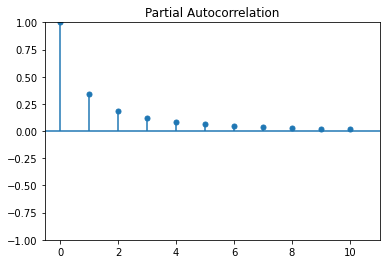

In [36]:
# If we would use autoregression:
lenOfDataToPredict = len(data_pred)

if lenOfDataToPredict < 10:
    lags=(lenOfDataToPredict/2)-1
else:
    lags=10

plot_pacf(data_pred.item_cnt_day_Ol, lags=lags)
plt.show()

#### Feature creation (lags and month of the year)

In [37]:
#sorting by items for lag creation
data_pred = data_pred.sort_values(by=['shop_id', 'item_id'])

#creating features for autoregression technique
data_pred['x1'] = data_pred.item_cnt_day_Ol.shift(1)
data_pred['x2'] = data_pred.item_cnt_day_Ol.shift(2)
data_pred['x3'] = data_pred.item_cnt_day_Ol.shift(3)

#feature engeneering
data_pred['month'] = data_pred.index.month
# data_pred['week'] = data_pred.index.week
# data_pred['day'] = data_pred.index.day


data_pred.dropna(axis=0, inplace=True)

data_pred.head()

,date_block_num,shop_id,item_id,item_price,item_category_id,item_cnt_day_Ol,category,x1,x2,x3,month
date,,,,,,,,,,,
2013-06-16,5,2,30,399.0,40,1.0,1,1.0,1.0,1.0,6
2014-04-20,15,2,30,169.0,40,1.0,1,1.0,1.0,1.0,4
2014-05-08,16,2,30,169.0,40,1.0,1,1.0,1.0,1.0,5
2013-02-28,1,2,31,699.0,37,1.0,1,1.0,1.0,1.0,2
2013-02-23,1,2,31,699.0,37,1.0,1,1.0,1.0,1.0,2


#### Dummies and normalization

In [38]:
#one hot encoding for the months
# onehot = pd.get_dummies(data_pred.month, drop_first=True, prefix="m")
# data_pred = data_pred.drop('month', axis=1)
data_pred = pd.get_dummies(data_pred, columns=['month'], drop_first=True, prefix="m")
data_pred = pd.get_dummies(data_pred, columns=['category'], drop_first=True, prefix="cat_")

#normalize item_price feature
toNormalizeData = data_pred['item_price']

scaler = StandardScaler().fit(toNormalizeData.values.reshape(-1,1))
toNormalizeData = scaler.transform(toNormalizeData.values.reshape(-1,1))

#Get the arrays generated back in the dataset
data_pred['item_price'] = toNormalizeData

data_pred

,date_block_num,shop_id,item_id,item_price,item_category_id,item_cnt_day_Ol,x1,x2,x3,m_2,...,cat__2,cat__3,cat__4,cat__5,cat__6,cat__7,cat__8,cat__9,cat__10,cat__11
date,,,,,,,,,,,,,,,,,,,,,
2013-06-16,5,2,30,-0.287497,40,1.0,1.0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
2014-04-20,15,2,30,-0.418502,40,1.0,1.0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
2014-05-08,16,2,30,-0.418502,40,1.0,1.0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
2013-02-28,1,2,31,-0.116621,37,1.0,1.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
2013-02-23,1,2,31,-0.116621,37,1.0,1.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-21,30,59,22164,-0.116621,37,1.0,1.0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
2013-10-25,9,59,22167,-0.344456,49,1.0,1.0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
2013-12-14,11,59,22167,-0.344456,49,1.0,1.0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
#group to predict by month, not by day as we have daily data
data_pred = data_pred.groupby(['date_block_num', 
                                'shop_id',
                                'item_id']).sum().reset_index()
                                
#remove aggregatiions on onehot encoded columns
listOfOHColumns = ['m_2','m_3','m_4','m_5','m_6','m_7','m_8','m_9','m_10','m_11','m_12']

for c in listOfOHColumns:
    data_pred[c] = np.where(data_pred[c] >= 1, 1,
                            data_pred[c])

In [40]:
#Solve the summed item category ID issue
tempItems = pd.merge(items_set, item_categories_set, on='item_category_id', how='left')
tempItems = tempItems[['item_id','item_category_id']]
tempItems

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40
...,...,...
22165,22165,31
22166,22166,54
22167,22167,49
22168,22168,62


In [41]:
data_pred = data_pred.drop('item_category_id', axis=1)
data_pred = pd.merge(data_pred, tempItems, on='item_id', how='left')
data_pred = data_pred.drop('item_category_id', axis=1)
data_pred

,date_block_num,shop_id,item_id,item_price,item_cnt_day_Ol,x1,x2,x3,m_2,m_3,...,cat__2,cat__3,cat__4,cat__5,cat__6,cat__7,cat__8,cat__9,cat__10,cat__11
0,0,2,33,-0.230538,1.0,1.0,1.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,317,-0.344456,1.0,1.0,1.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,438,-0.344456,1.0,1.0,1.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,471,-0.574994,2.0,2.0,2.0,2.0,0,0,...,2,0,0,0,0,0,0,0,0,0
4,0,2,481,-0.326799,1.0,1.0,1.0,1.0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334647,33,59,22087,-1.340945,6.0,7.0,5.0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1334648,33,59,22088,-0.893963,2.0,2.0,2.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1334649,33,59,22091,-0.412806,1.0,1.0,1.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1334650,33,59,22100,-0.156492,1.0,1.0,1.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Train and test split

In [42]:
randomState = 12

X = data_pred.copy()
y = X.pop('item_cnt_day_Ol')

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 1
                                                    )

#### Best performance model (LGBM)

After testing few models using a Pipeline technique, I decided to focus on the LGBM model, as it has showed best scores

In [43]:
lgbm = LGBMRegressor(learning_rate= 0.2,
                     max_depth= 20,
                     num_leaves= 150,
                     subsample= 0.4).fit(X_train, y_train)

predictions_LGBM = np.around(lgbm.predict(X_test), decimals=1)


print('RMSE for lgbm was: \n', mean_squared_error(y_test, predictions_LGBM, squared=False))
print('==============='*5)

RMSE for lgbm was: 
 0.30291648104957963


RMSE for lgbm on all data was: 
 0.2781367126601787


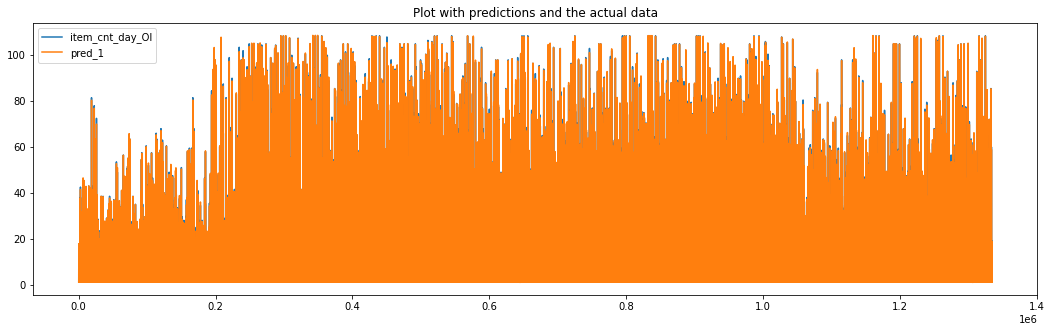

In [44]:
data_pred['pred_1'] = np.around(lgbm.predict(X), decimals=1)
data_pred[['item_cnt_day_Ol', 'pred_1']].plot(figsize=figsize, title='Plot with predictions and the actual data')

print('RMSE for lgbm on all data was: \n', mean_squared_error(data_pred['item_cnt_day_Ol'], data_pred['pred_1'], squared=False))

<AxesSubplot:title={'center':'Plot with predictions and the actual data'}>

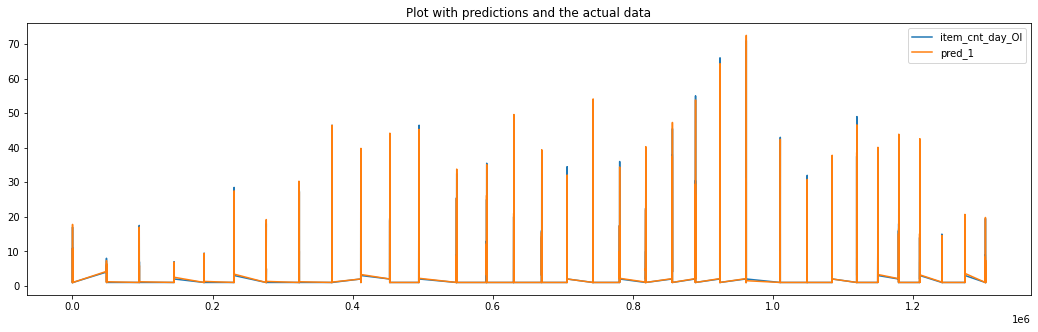

In [45]:
data_pred.query('shop_id==2')[['item_cnt_day_Ol', 'pred_1']].plot(figsize=figsize, title='Plot with predictions and the actual data')

### Final model to run predictions:

In [46]:
lgbm = LGBMRegressor(learning_rate= 0.2,
                     max_depth= 20,
                     num_leaves= 150,
                     subsample= 0.4).fit(X, y)


I will insert in the data set that will be used for the predictions, the same variables created for the test set. These variables do not exist in the original data and therefore need to be added so that the model has the same capabilities for the final prediction. 

In [47]:
test_set_merge = pd.merge(test_set, data_pred[['item_id', 'shop_id', 'item_price', 
                                                'cat__1', 'cat__2', 'cat__3', 'cat__4', 'cat__5', 'cat__6', 
                                                'cat__7', 'cat__8', 'cat__9', 'cat__10', 'cat__11']], on=['item_id', 'shop_id'], how='left')

#removing duplicates
test_set = pd.merge(test_set, test_set_merge.drop_duplicates(['ID']), on=['ID', 'item_id', 'shop_id'], how='left')

#remove nans from items with no values on original data
test_set = test_set.fillna(0)

#insert next month index
test_set['date_block_num'] = data_pred.date_block_num.max() + 1

#drop ID
# test_set = test_set.drop('ID', axis=1)

#add month encoded columns to test data
test_set[['m_2','m_3','m_4','m_5','m_6','m_7','m_8','m_9','m_10','m_11','m_12']] = [0,0,0,0,0,0,0,0,0,1,0] #as the forecast will use the november as month
test_set[['x1', 'x2', 'x3']] = [None,None,None]

#Vizualize
test_set.query('item_id == 5233 & shop_id == 5')

,ID,shop_id,item_id,item_price,cat__1,cat__2,cat__3,cat__4,cat__5,cat__6,...,m_6,m_7,m_8,m_9,m_10,m_11,m_12,x1,x2,x3
2,2,5,5233,-0.005406,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,None,None,None


In [48]:
#reorder columns to match the training dataset
test_set = test_set[X_test.columns]

In [49]:
#concatenating the datasets, so I will be able to fill lags with actual data from previous months
temp_test = pd.concat([data_pred, test_set], keys=["x", "y"])
temp_test

date_block_num  shop_id  item_id  item_price  item_cnt_day_Ol   x1  \
x 0                    0        2       33   -0.230538              1.0  1.0   
  1                    0        2      317   -0.344456              1.0  1.0   
  2                    0        2      438   -0.344456              1.0  1.0   
  3                    0        2      471   -0.574994              2.0  2.0   
  4                    0        2      481   -0.326799              1.0  1.0   
...                  ...      ...      ...         ...              ...  ...   
y 214195              34       45    18454   -1.605659              NaN  NaN   
  214196              34       45    16188    0.000000              NaN  NaN   
  214197              34       45    15757   -0.401415              NaN  NaN   
  214198              34       45    19648    0.000000              NaN  NaN   
  214199              34       45      969   -0.404118              NaN  NaN   

           x2   x3  m_2  m_3  ...  cat__3  cat__4  cat__5  cat__6  cat__7  \
x 0       1.0  1.0    0    0  ...     0.0     0.0     0.0     0.0     0.0   
  1       1.0  1.0    0    0  ...     0.0     0.0     0.0     0.0     0.0   
  2       1.0  1.0    0    0  ...     0.0     0.0     0.0     0.0     0.0   
  3       2.0  2.0    0    0  ...     0.0     0.0     0.0     0.0     0.0   
  4       1.0  1.0    0    0  ...     0.0     0.0     0.0     0.0     0.0   
...       ...  ...  ...  ...  ...     ...     ...     ...     ...     ...   
y 214195  NaN  NaN    0    0  ...     0.0     0.0     0.0     0.0     0.0   
  214196  NaN  NaN    0    0  ...     0.0     0.0     0.0     0.0     0.0   
  214197  NaN  NaN    0    0  ...     0.0     0.0     0.0     0.0     0.0   
  214198  NaN  NaN    0    0  ...     0.0     0.0     0.0     0.0     0.0   
  214199  NaN  NaN    0    0  ...     0.0     0.0     0.0     0.0     0.0   

          cat__8  cat__9  cat__10  cat__11  pred_1  
x 0          0.0     0.0      0.0      0.0     1.0  
  1          0.0     0.0      0.0      0.0     1.0  
  2          0.0     0.0      0.0      0.0     1.0  
  3          0.0     0.0      0.0      0.0     2.0  
  4          0.0     0.0      0.0      0.0     1.0  
...          ...     ...      ...      ...     ...  
y 214195     0.0     0.0      0.0      0.0     NaN  
  214196     0.0     0.0      0.0      0.0     NaN  
  214197     0.0     0.0      0.0      0.0     NaN  
  214198     0.0     0.0      0.0      0.0     NaN  
  214199     0.0     0.0      0.0      0.0     NaN  

[1548852 rows x 31 columns]

In [50]:
#just to vizualize if the concat did it well
temp_test.sort_values(by=['shop_id', 'item_id', 'date_block_num']).head(20)

date_block_num  shop_id  item_id  item_price  item_cnt_day_Ol   x1  \
x 230375                5        2       30   -0.287497              1.0  1.0   
  669535               15        2       30   -0.418502              1.0  1.0   
  705734               16        2       30   -0.418502              1.0  1.0   
y 22987                34        2       30   -0.287497              NaN  NaN   
x 48487                 1        2       31   -0.466482              4.0  4.0   
  95111                 2        2       31   -0.116905              1.0  1.0   
  144830                3        2       31   -0.116621              1.0  1.0   
  705735               16        2       31   -0.277860              1.0  1.0   
  1303121              33        2       31   -0.287497              1.0  1.0   
y 20994                34        2       31   -0.466482              NaN  NaN   
x 548106               12        2       32   -0.446982              1.0  1.0   
  629740               14        2       32   -0.429894              1.0  1.0   
  780806               18        2       32   -0.429894              1.0  1.0   
  856135               20        2       32   -0.859788              2.0  2.0   
  889111               21        2       32   -0.859788              2.0  2.0   
  961290               23        2       32   -0.859788              2.0  2.0   
  1084176              26        2       32   -0.429894              1.0  1.0   
  1241080              31        2       32   -0.429894              1.0  1.0   
y 20995                34        2       32   -0.446982              NaN  NaN   
x 0                     0        2       33   -0.230538              1.0  1.0   

            x2   x3  m_2  m_3  ...  cat__3  cat__4  cat__5  cat__6  cat__7  \
x 230375   1.0  1.0    0    0  ...     0.0     0.0     0.0     0.0     0.0   
  669535   1.0  1.0    0    0  ...     0.0     0.0     0.0     0.0     0.0   
  705734   1.0  1.0    0    0  ...     0.0     0.0     0.0     0.0     0.0   
y 22987    NaN  NaN    0    0  ...     0.0     0.0     0.0     0.0     0.0   
x 48487    4.0  4.0    1    0  ...     0.0     0.0     0.0     0.0     0.0   
  95111    1.0  1.0    0    1  ...     0.0     0.0     0.0     0.0     0.0   
  144830   1.0  1.0    0    0  ...     0.0     0.0     0.0     0.0     0.0   
  705735   1.0  1.0    0    0  ...     0.0     0.0     0.0     0.0     0.0   
  1303121  1.0  1.0    0    0  ...     0.0     0.0     0.0     0.0     0.0   
y 20994    NaN  NaN    0    0  ...     0.0     0.0     0.0     0.0     0.0   
x 548106   1.0  1.0    0    0  ...     1.0     0.0     0.0     0.0     0.0   
  629740   1.0  1.0    0    1  ...     1.0     0.0     0.0     0.0     0.0   
  780806   1.0  1.0    0    0  ...     1.0     0.0     0.0     0.0     0.0   
  856135   2.0  2.0    0    0  ...     2.0     0.0     0.0     0.0     0.0   
  889111   2.0  2.0    0    0  ...     2.0     0.0     0.0     0.0     0.0   
  961290   2.0  2.0    0    0  ...     2.0     0.0     0.0     0.0     0.0   
  1084176  1.0  1.0    0    1  ...     1.0     0.0     0.0     0.0     0.0   
  1241080  1.0  1.0    0    0  ...     1.0     0.0     0.0     0.0     0.0   
y 20995    NaN  NaN    0    0  ...     1.0     0.0     0.0     0.0     0.0   
x 0        1.0  1.0    0    0  ...     0.0     0.0     0.0     0.0     0.0   

           cat__8  cat__9  cat__10  cat__11  pred_1  
x 230375      0.0     0.0      0.0      0.0     1.0  
  669535      0.0     0.0      0.0      0.0     1.0  
  705734      0.0     0.0      0.0      0.0     1.0  
y 22987       0.0     0.0      0.0      0.0     NaN  
x 48487       0.0     0.0      0.0      0.0     4.2  
  95111       0.0     0.0      0.0      0.0     1.0  
  144830      0.0     0.0      0.0      0.0     1.0  
  705735      0.0     0.0      0.0      0.0     1.0  
  1303121     0.0     0.0      0.0      0.0     1.0  
y 20994       0.0     0.0      0.0      0.0     NaN  
x 548106      0.0     0.0      0.0      0.0     1.0  
  629740      0.0     

In [51]:
#remove aggregatiions on onehot encoded columns
listOfOHColumns = ['cat__1', 'cat__2', 'cat__3', 'cat__4', 'cat__5', 'cat__6', 'cat__7', 'cat__8', 'cat__9', 'cat__10', 'cat__11']

for c in listOfOHColumns:
    temp_test[c] = np.where(temp_test[c] >= 1, 1,
                            temp_test[c])

In [52]:
#creating features for autoregression technique
temp_test = temp_test.sort_values(by=['shop_id', 'item_id', 'date_block_num'])

temp_test['x1'] = temp_test['x1'].fillna(temp_test.item_cnt_day_Ol.shift(1))
temp_test['x2'] = temp_test['x2'].fillna(temp_test.item_cnt_day_Ol.shift(2))
temp_test['x3'] = temp_test['x3'].fillna(temp_test.item_cnt_day_Ol.shift(3))

#fill residual NaNs with 1
temp_test = temp_test.loc['y'].fillna(1)

In [53]:
test_set = temp_test[X.columns].sort_index()

### Prediction of the trained model using the given test dataset 

In [54]:
test_set['pred'] = np.around(lgbm.predict(test_set), decimals=1)

In [55]:
#Items on test set that we do not have on train sets.
itemsNotInTrain = test_set.item_id[~test_set.item_id.isin(data_pred.item_id)]

# fill predictions to 0 for this items
test_set['pred'] = test_set.pred.where(test_set.item_id.isin(itemsNotInTrain), 0)

In [56]:
test_set

,date_block_num,shop_id,item_id,item_price,x1,x2,x3,m_2,m_3,m_4,...,cat__3,cat__4,cat__5,cat__6,cat__7,cat__8,cat__9,cat__10,cat__11,pred
0,34,5,5037,0.965597,1.0,3.0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34,5,5320,0.000000,1.0,3.0,2.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
2,34,5,5233,-0.005406,1.0,3.0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34,5,5232,-0.173579,1.0,1.0,2.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,34,5,5268,0.000000,3.0,1.0,2.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,34,45,18454,-1.605659,1.0,1.0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214196,34,45,16188,0.000000,1.0,1.0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,34,45,15757,-0.401415,1.0,1.0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,34,45,19648,0.000000,1.0,1.0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
test_set['pred'].describe()

count    214200.000000
mean          0.075037
std           0.285991
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          16.700000
Name: pred, dtype: float64

The final result for this notebook was a RMSE of 1.24015

# References

https://github.com/lukewhyte/textpack

https://www.kaggle.com/code/deinforcement/top-1-predict-future-sales-features-lightgbm/

https://github.com/seatgeek/thefuzz